In [4]:
import geopandas as gpd
import pandas as pd
import rasterio
import rasterstats as rs
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../../snow_terrain_tiles/')
from dem_utils import recursive_rastersstats_to_dict

In [5]:
# Function to compute zonal raster statistics using rasterstats library
# for single shapefile and many rasters inside a single directory
# Returns geodataframe

def compute_drift_statistics(regx, shp):
    d = recursive_rastersstats_to_dict(regx, '*_corrected*')
    geodf = gpd.read_file(shp)
    stats=['mean', 'std', 'median', 'sum']

    for k in d.keys():

        col_name = str(d[k]['year'][0])

        zonal_d = (rs.zonal_stats(geodf, k,
                                 stats=stats))
        geodf[col_name] = zonal_d
        
        for st in stats:
    
            st_series = geodf[col_name].apply(lambda x: x.get(st))
            yr_st_name = col_name + '_' + st
            geodf[yr_st_name] = st_series

        del geodf[col_name]
        
    return geodf
    

In [3]:
# compute stats with our function. combine hv and clpx results
hv = compute_drift_statistics('../../depth_dDEMs/hv/', '../gis/hv_drifts.shp')
clpx = compute_drift_statistics('../../depth_dDEMs/clpx/', '../gis/clpx_drifts.shp')
geodf = pd.concat([hv, clpx], sort=False)
len(hv) + len(clpx) == len(geodf)

../../snow_terrain_tiles/dem_utils.py:149: RuntimeWarning: invalid value encountered in less
  arr[arr < -9999] = np.nan


True

In [6]:
# Lots of NoData from 2012/2013 lidar acquisitions

geodf_15on = geodf.dropna(axis=1)
geodf_15on.columns

Index(['drift_type', 'study_area', 'geometry', '2015_mean', '2015_std',
       '2015_median', '2015_sum', '2018_mean', '2018_std', '2018_median',
       '2018_sum', '2016_mean', '2016_std', '2016_median', '2016_sum',
       '2017_mean', '2017_std', '2017_median', '2017_sum'],
      dtype='object')

In [7]:
# Get time series averages (e.g. mean of means)
all_means = geodf_15on.filter(regex='mean', axis=1)
all_std = geodf_15on.filter(regex='std', axis=1)
all_volumes = geodf_15on.filter(regex='sum', axis=1)
all_meds = geodf_15on.filter(regex='median', axis=1)

ts_mean = all_means.mean(axis=1)
ts_std = all_std.mean(axis=1)
ts_vol = all_volumes.mean(axis=1)
ts_med = all_meds.mean(axis=1)

summary_df = pd.DataFrame()
summary_df['Drift Type'] = geodf_15on.drift_type
summary_df['Study Area'] = [s.upper() for s in geodf_15on.study_area]
summary_df['Drift Area [m^2]'] = geodf_15on.area

summary_df['Mean Drift Depth [m]'] = ts_mean
summary_df['Mean Drift Volume [m^3]'] = ts_vol
summary_df['Std. Drift Depth [m]'] = ts_std
summary_df['Median Drift Depth [m]'] = ts_med

summary_df['CV Drift Depth'] = ts_std / ts_mean
summary_df['Volume:Area Ratio'] = ts_vol / summary_df['Drift Area [m^2]']

summary_df.head(3)

,Drift Type,Study Area,Drift Area [m^2],Mean Drift Depth [m],Mean Drift Volume [m^3],Std. Drift Depth [m],Median Drift Depth [m],CV Drift Depth,Volume:Area Ratio
0,watertrack,HV,23636.367493,0.776019,18053.440430,0.171731,0.791751,0.221298,0.763799
1,watertrack,HV,9069.760465,0.777382,7044.636963,0.203242,0.755424,0.261444,0.776717
2,watertrack,HV,27802.663732,1.093303,30428.813477,0.414733,1.105991,0.379340,1.094457


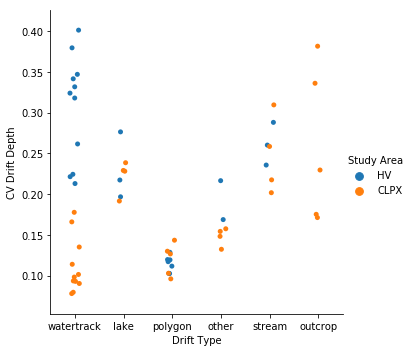

In [8]:
sns.catplot(x="Drift Type", y="CV Drift Depth", hue='Study Area', data=summary_df)
plt.savefig('../figs/drift_type_x_cv_depth_y.png', dpi=300, bbox_inches='tight')

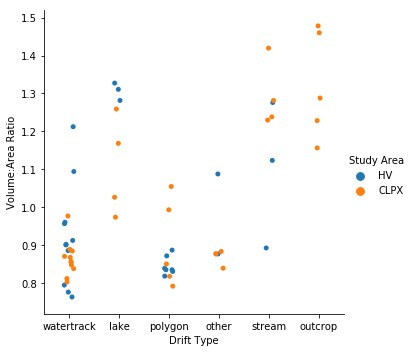

In [9]:
sns.catplot(x="Drift Type", y="Volume:Area Ratio", hue='Study Area',
            data=summary_df)
plt.savefig('../figs/drift_type_x_volume_area_volume_ratio_y.png', dpi=300, bbox_inches='tight')

In [71]:
summary_df.round(3).to_csv('../results/drift_classification_summary.csv', index=False)

In [18]:
summary_df['Volume:Area Ratio'].max()

1.4780299278779883

In [16]:
summary_df.groupby(['Study Area','Drift Type']).mean()

Drift Area [m^2]  Mean Drift Depth [m]  \
Study Area Drift Type                                           
CLPX       lake            23832.873860              1.106571   
           other          212890.410534              0.869638   
           outcrop          5432.366359              1.320414   
           polygon           370.171964              0.889683   
           stream          20247.729033              1.292868   
           watertrack       2288.217920              0.865197   
HV         lake            71679.399267              1.306417   
           other           12722.104572              0.981453   
           polygon           850.860199              0.840436   
           stream           2182.592646              1.096035   
           watertrack      20968.369590              0.925427   

                       Mean Drift Volume [m^3]  Std. Drift Depth [m]  \
Study Area Drift Type                                                  
CLPX       lake                   26790.934174              0.246943   
           other                 186951.752441              0.128709   
           outcrop                 7523.191309              0.352037   
           polygon                  350.697800              0.108080   
           stream                 25456.217468              0.316979   
           watertrack              2056.387101              0.097707   
HV         lake                   93953.466146              0.300889   
           other                  11358.397369              0.191457   
           polygon                  720.395253              0.096246   
           stream                  2420.860860              0.289626   
           watertrack             20217.424300              0.283517   

                       Median Drift Depth [m]  CV Drift Depth  \
Study Area Drift Type                                           
CLPX       lake                      1.087166        0.221708   
           other                     0.857323        0.147995   
           outcrop                   1.312603        0.258607   
           polygon                   0.877632        0.119734   
           stream                    1.280365        0.246699   
           watertrack                0.855307        0.111459   
HV         lake                      1.317284        0.230033   
           other                     0.983466        0.192539   
           polygon                   0.839329        0.114451   
           stream                    1.085368        0.261189   
           watertrack                0.879222        0.305597   

                       Volume:Area Ratio  
Study Area Drift Type                     
CLPX       lake                 1.107087  
           other                0.869662  
           outcrop              1.322270  
           polygon              0.901972  
           stream               1.292298  
           watertrack           0.864205  
HV         lake                 1.306681  
           other                0.982561  
           polygon              0.845680  
           stream               1.097643  
           watertrack           0.923877

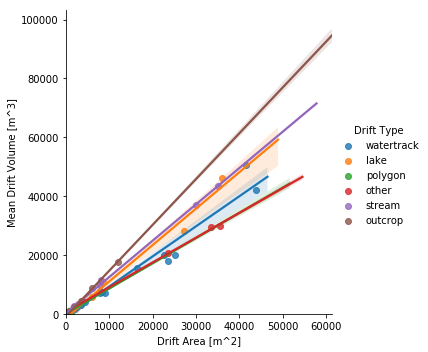

In [69]:
dfless100k = summary_df.drop(summary_df.index[summary_df['Drift Area [m^2]'] > 50000])
#dfless100k
sns.lmplot(x="Drift Area [m^2]", y="Mean Drift Volume [m^3]", hue="Drift Type", ci=68,
           data=dfless100k)
plt.xlim(0)
plt.ylim(0)
plt.savefig('../figs/area_vol_regression_by_drift_type.png', dpi=300, bbox_inches='tight')

In [19]:
summary_df.groupby(['Drift Type']).count()

,Study Area,Drift Area [m^2],Mean Drift Depth [m],Mean Drift Volume [m^3],Std. Drift Depth [m],Median Drift Depth [m],CV Drift Depth,Volume:Area Ratio
Drift Type,,,,,,,,
lake,7,7,7,7,7,7,7,7
other,6,6,6,6,6,6,6,6
outcrop,5,5,5,5,5,5,5,5
polygon,12,12,12,12,12,12,12,12
stream,7,7,7,7,7,7,7,7
watertrack,22,22,22,22,22,22,22,22


In [20]:
bytype = summary_df.groupby(['Drift Type']).mean()

In [40]:
x = summary_df['Drift Area [m^2]']
               
y = summary_df['Mean Drift Volume [m^3]']


In [41]:
xclip = x.drop(y.index[y>100000])
yclip = y.drop(y.index[y>100000])
len(xclip) == len(yclip)


True

In [42]:
from scipy import stats

import numpy as np

gradient,intercept,r_value,p_value,std_err=stats.linregress(xclip ,yclip)

print("Gradient and intercept",gradient,intercept)


print ("R-squared",r_value**2)

print ("p-value",p_value)


Gradient and intercept 1.1345316620271544 -713.7967873688103
R-squared 0.9592636705957239
p-value 1.6254371058097125e-38


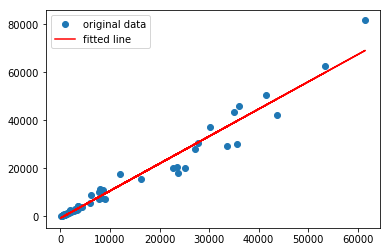

In [44]:
plt.plot(xclip, yclip, 'o', label='original data')
plt.plot(xclip, intercept + gradient * xclip, 'r', label='fitted line')
plt.legend()
plt.show()

In [ ]:
# to retreive shape properties - can do this later if useful
# not relevant at the moment 7/25/19

from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import binary_dilation
import matplotlib.patches as mpatches

src = rasterio.open('drift_masks/hv_drifts_rasterized.tif')
arr = src.read(1)
msk = (arr > -1).astype(int)
be_msk = binary_dilation(msk)

In [ ]:
label_image = label(be_msk, connectivity=2, background=0)
areas = []
eccs = []
orientations = []
ctrxs = []
ctrys = []

for region in regionprops(label_image):
    areas.append(region.area)
    eccs.append(region.eccentricity)
    orientations.append(region.orientation)
    ctrxs.append(region.centroid[1] + 421000)
    ctrys.append(7678000 - region.centroid[0])
    

df = pd.DataFrame([areas,eccs,orientations,ctrxs, ctrys])

In [ ]:
shapedf = df.T
shapedf.columns = ['area', 'eccentricity', 'orientation', 'x', 'y']
shapedf.sort_values('x', inplace=True)
shapedf.head(3)

In [ ]:
hv['gdfctrx'] = [int(x) for x in hv.geometry.centroid.x]
hv_copy = hv.sort_values('gdfctrx')

#hv_copy
hv_copy.head(3)

In [ ]:
hv_copy['orientation'] = shapedf['orientation']
hv_copy['eccentricity'] = shapedf['eccentricity']


In [ ]:
shapedf['drift_type'] = hv_copy.drift_type

In [ ]:
sns.catplot(x="drift_type", y="eccentricity", data=shapedf)

In [ ]:
gdf_ctr_x = [int(x) for x in hv.geometry.centroid.x]
gdf_ctr_y = [int(y) for y in hv.geometry.centroid.y]
rprops_ctrx = [c[1] + 421000 for c in ctrs]
rprops_ctry = [7678000 - c[0] for c in ctrs]

In [ ]:
xdelt = np.sort(gdf_ctr_x) - np.sort(rprops_ctrx)
ydelt = np.sort(gdf_ctr_y) - np.sort(rprops_ctry)
np.sqrt(xdelt**2 + ydelt**2)